# Prediction of child's IQ
Julia Krysiak, Sylwia Michalska

## Introduction
In this project we created two different models for predicting child's IQ based on the characteristics of the mother. Despite the controversy surrounding the measurement and significance of IQ, there are practical reasons why predicting IQ can still be useful.

### Controversy around IQ
IQ, or Intelligence Quotient, has long been a subject of debate. Critics argue that IQ tests are culturally biased, do not capture the full spectrum of human intelligence, and may not accurately reflect an individual's cognitive abilities or potential. Research has shown that factors such as socio-economic status, educational opportunities, and even test anxiety can significantly impact IQ scores, calling into question their reliability and validity as a measure of intelligence.

Furthermore, multiple studies suggest that intelligence is multifaceted and cannot be encapsulated by a single numerical score. Howard Gardner's theory of multiple intelligences, for instance, proposes that individuals possess a variety of distinct cognitive abilities, such as linguistic, logical-mathematical, spatial, and interpersonal intelligences, which are not adequately assessed by traditional IQ tests.

### Why prediction of IQ may be useful
While IQ is a controversial measure with significant limitations, its prediction can still offer practical benefits. IQ scores remain widely used in educational and psychological assessments for several practical reasons:
1. Educational Planning: IQ scores can help identify children who may need special educational support. Schools and educators can use this information to tailor educational strategies, design individualized education programs (IEPs), and allocate resources effectively.
2. Parental Guidance: Predicting a child's IQ based on socio-economic and parental factors can provide valuable insights for parents. Understanding how their actions and environment influence their child's cognitive development can help them make informed decisions about education, health, and enrichment activities.
3. Policy Making: Policy makers can use aggregated IQ data to inform decisions on early childhood education programs, social welfare initiatives, and resource allocation. For instance, identifying regions with lower average IQ scores may prompt interventions to improve educational and socio-economic conditions.
4. Research: IQ data, despite its limitations, provides a useful benchmark for psychological and educational research. It can help researchers study the impact of various factors on cognitive development and evaluate the effectiveness of interventions aimed at improving educational outcomes.

## Directed Acyclic Graph


<img title="Directed Acyclic Graph" src="images/children’s IQ.png">

## Data Source and Contents
We used `kidiq` dataset which is available in the [`statsmodels`](https://www.statsmodels.org/dev/datasets/index.html) datasets package. Data includes information on children's IQ scores and various socio-economic and parental factors. It contains following variables:

- **kid_score**: child's IQ score,
- **mom_hs**: indicator for whether the mother has a high school degree, which takes values from the set: {0,1},
- **mom_work**: value designed to capture and categorize the employment status of a mother during the early years of her child's life as follows:

    - 1 -> did not work in first three years of child's life,
    - 2 -> worked in 2nd or 3rd year of child's life,
    - 3 -> worked part-time in first year of child's life,
    - 4 -> worked full-time in first year of child's life.

- **mom_age**: mother's age.



## Data preprocessing


In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import arviz as az
from cmdstanpy import CmdStanModel

Firstly, we have displayed the data to see the structure and samples of data records:

In [102]:
df = pd.read_csv("data/kidiq.csv", sep=";")
df.head()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,1,121.117529,4,27
1,98,1,89.361882,4,25
2,85,1,115.443165,4,27
3,83,1,99.449639,3,25
4,115,1,92.745710,4,27


Next, we have checked if there are any null values in our dataset:

In [103]:
df.isnull().sum()

kid_score    0
mom_hs       0
mom_iq       0
mom_work     0
mom_age      0
dtype: int64

We also have used the `describe` function to check the statistics regards the dataframe and provide more details about the each column of data:

In [104]:
df.describe()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
count,99.000000,99.000000,99.000000,99.000000,99.000000
mean,91.363636,0.818182,103.149581,2.838384,23.383838
std,17.374303,0.387657,15.415122,1.201250,2.686729
min,42.000000,0.000000,76.575647,1.000000,17.000000
25%,79.500000,1.000000,90.772626,2.000000,21.500000
50%,95.000000,1.000000,100.534072,3.000000,24.000000
75%,103.500000,1.000000,113.411657,4.000000,25.000000
max,130.000000,1.000000,138.893106,4.000000,29.000000


Finally, we have analysed the correlation between the data. This step involves calculating the correlation coefficients between different variables in the dataset to understand the relationships between them. What we found is that there is moderate positive $kid.score$ ~
` $mom.iq$ and $kid.score$ ~ $mom.hs$ correlation. This indicates that those could be good predictiors for our models. The variables dependencies were presented using the corallation matrix visualized with a heatmap.

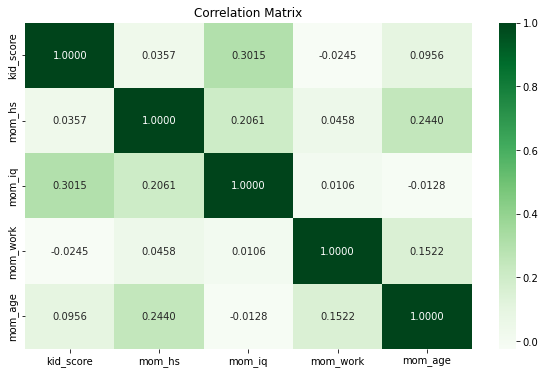

In [105]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True,cmap='Greens', fmt=".4f")
plt.title('Correlation Matrix')
plt.show()

### Plotting data

In order to observe the relationships between the variables we selected for further consideration as parameters in our models, we created the following plots showing:

- the dependency beetwen the child and mom IQ score:

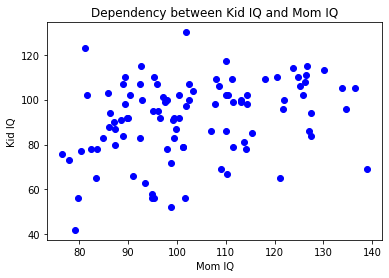

In [106]:
plt.scatter(df.mom_iq.values, df.kid_score.values, color='blue')
plt.title("Dependency between Kid IQ and Mom IQ")
plt.xlabel("Mom IQ")
plt.ylabel("Kid IQ")
plt.show()

- the dependency beetwen the child IQ score and mom hs indicator:

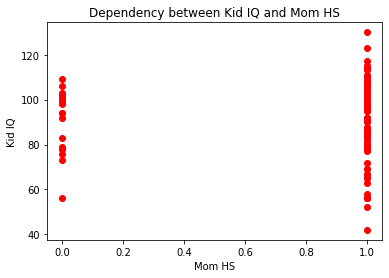

In [107]:
plt.scatter(df.mom_hs.values, df.kid_score.values, color='red')
plt.title("Dependency between Kid IQ and Mom HS")
plt.xlabel("Mom HS")
plt.ylabel("Kid IQ")
plt.show()

The purpose of visualizing the variables `kid_score`, `mom_iq`, and `mom_hs` using histograms was to show the distribution of these data for a better understanding of the respective features and relationships, as well as to check for potential outlier values.

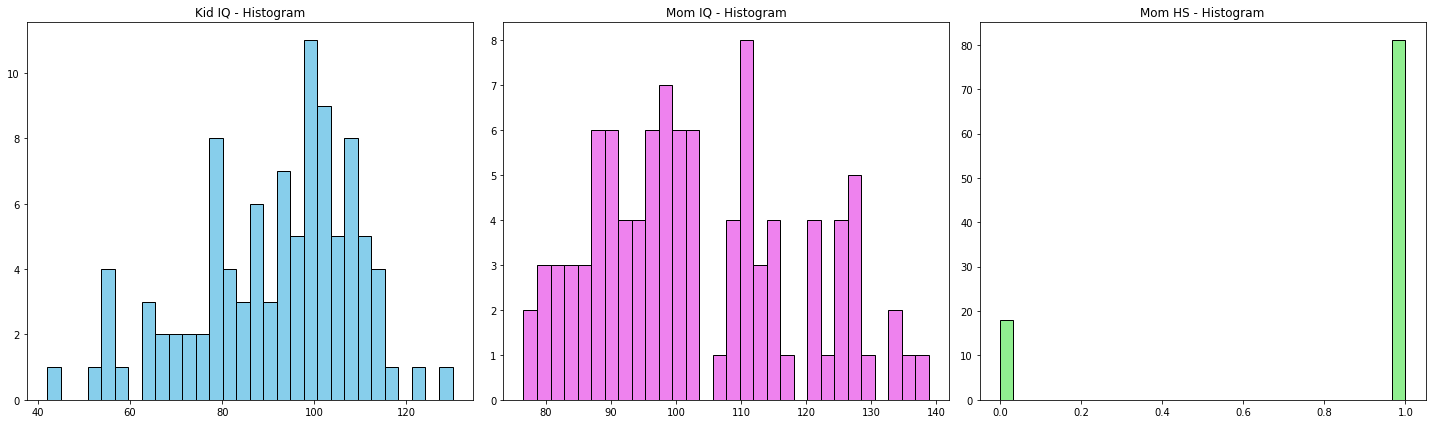

In [108]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))  

axs[0].hist(df.kid_score.values, bins=30, color='skyblue', edgecolor='black')
axs[0].set_title('Kid IQ - Histogram')

axs[1].hist(df.mom_iq.values, bins=30, color='violet', edgecolor='black')
axs[1].set_title('Mom IQ - Histogram')

axs[2].hist(df.mom_hs.values, bins=30, color='lightgreen', edgecolor='black')
axs[2].set_title('Mom HS - Histogram')

plt.tight_layout()
plt.show()

After analyzing the histograms, we concluded that there are no signs of extreme or outlier values in our data that significantly deviate from the rest of the data. Additionally, there are no NaN's values in the entire dataset, and all variables are represented by numerical data, which can be subjected to statistical analysis.

#  Model 1
Our first model is a simple linear regression model designed to predict a child's IQ score based on the mother's IQ score. This foundational model allows us to investigate the relationship between these two variables and serves as a starting point for more complex analyses. It can be described as:
$$kid.score_i \sim N(\mu_i, \sigma)$$
$$\mu_i = \beta_0 + \beta_1mom.iq_i$$


## Priors
In selecting priors for our Bayesian model, we considered both the characteristics of the given data and the distributions recommended by Mark Lai in his book "Course Handouts for Bayesian Data Analysis Class" (2019). Below, we briefly describe each parameter and its corresponding prior distribution:
1. $\beta_0$ - regression intercept: this is the expected IQ score of a child when the mother's IQ score is zero; chosen prior distribution:
$$\beta_0 \sim N(90, 15)$$
2. $\beta_1$ - slope: indicates the expected change in a child's IQ score for each one-point increase in the mother's IQ score, this parameter captures the strength and direction of the relationship between maternal and child IQ; chosen prior distribution:
$$\beta_1 \sim N(0, 1)$$
3. $\sigma$ - error standard deviation: represents the variability of child IQ scores among those with the same maternal IQ score, it accounts for the unobserved factors affecting child IQ and is assumed to be constant across different levels of maternal IQ; chosen prior distribution (recommended in Gelman, Andrew. 2006. “Prior distributions for variance parameters in hierarchical models (Comment on Article by Browne and Draper).” Bayesian Analysis 1 (3): 515–34):
$$\sigma \sim t^+(4, 0, 1)$$






### STAN

```stan
data {
  int<lower=0> N;               
  array[N] real mom_iq;        
}

generated quantities {
  real beta0 = normal_rng(90, 15);   
  real beta1 = normal_rng(0, 1);     
  real sigma = student_t_rng(4, 0, 1);

  array[N] real kid_score; 
  for (i in 1:N) {
    kid_score[i] = normal_rng(beta0 + beta1*mom_iq[i], sigma);  
  }
}

```

### Simulating data
Centering mother's IQ scores by subtracting the mean ensures that the intercept $\beta_0$ accurately reflects the expected child's IQ score when the mother's IQ is average. Subsequently, we created a simulated dataset that closely mimics the range and distribution of the actual data. The decision to simulate the data comes from the necessity to validate its functionality and to gain insights into its behavior under controlled conditions.

In [109]:
mean_mom_iq = df.mom_iq.mean()
df['c_mom_iq'] = df.mom_iq - mean_mom_iq
data_sim={'N':df.shape[0], 'mom_iq':np.linspace(df.c_mom_iq.min(),df.c_mom_iq.max(), num=df.shape[0])}

In [110]:
model_1=CmdStanModel(stan_file='stan_models/prior1.stan')

model_1_samp = model_1.sample(data = data_sim, chains=4, seed=2904)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:   1 / 1000 [  0%]  (Sampling)

chain 1 |████      | 00:00 Iteration: 700 / 1000 [ 70%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed                      

chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


In [111]:
kid_pred_prior = model_1_samp.stan_variable("kid_score")

In [112]:
print(model_1_samp.summary())

                Mean   MCSE  StdDev   5%  50%    95%   N_Eff  N_Eff/s  R_hat
name                                                                        
lp__            0.00    NaN    0.00  0.0  0.0    0.0     NaN      NaN    NaN
beta0          45.00  0.780   47.00  0.0  0.0  110.0  3500.0   6000.0    1.0
beta1           0.02  0.011    0.71 -1.2  0.0    1.3  4000.0   6800.0    1.0
sigma           0.49  0.013    0.80  0.0  0.0    2.1  3900.0   6700.0    1.0
kid_score[1]   44.00  0.830   50.00  0.0  0.0  128.0  3623.0   6182.0    1.0
...              ...    ...     ...  ...  ...    ...     ...      ...    ...
kid_score[95]  46.00  0.870   53.00  0.0  0.0  140.0  3646.0   6222.0    1.0
kid_score[96]  46.00  0.880   53.00  0.0  0.0  141.0  3645.0   6221.0    1.0
kid_score[97]  46.00  0.880   53.00  0.0  0.0  142.0  3628.0   6191.0    1.0
kid_score[98]  46.00  0.880   53.00  0.0  0.0  142.0  3644.0   6218.0    1.0
kid_score[99]  46.00  0.890   54.00  0.0  0.0  142.0  3644.0   6218.0    1.0

### Sampled slopes
For each sampled slope beta and intercept alpha lines has been plotted. Slopes are more or less between minimum and maximum possible IQs which would imply that the chosen priors are satisfactory.

/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


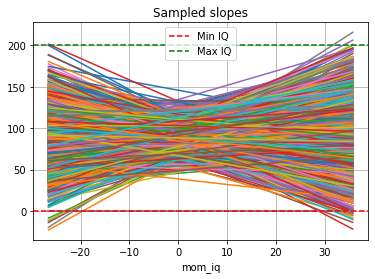

In [113]:
betas0 = model_1_samp.stan_variable('beta0')
betas1 = model_1_samp.stan_variable('beta1')

mom_iq = data_sim['mom_iq']

for beta0, beta1 in zip(betas0, betas1):
    plt.plot(mom_iq, mom_iq * beta1 + beta0)
    plt.xlabel('mom_iq')

min_iq = 0 
max_iq = 200 

plt.axhline(y=min_iq, color='red', linestyle='--', label='Min IQ')
plt.axhline(y=max_iq, color='green', linestyle='--', label='Max IQ')

plt.grid(True)
plt.legend()
plt.title("Sampled slopes")
plt.show()

### Comparison of measurements

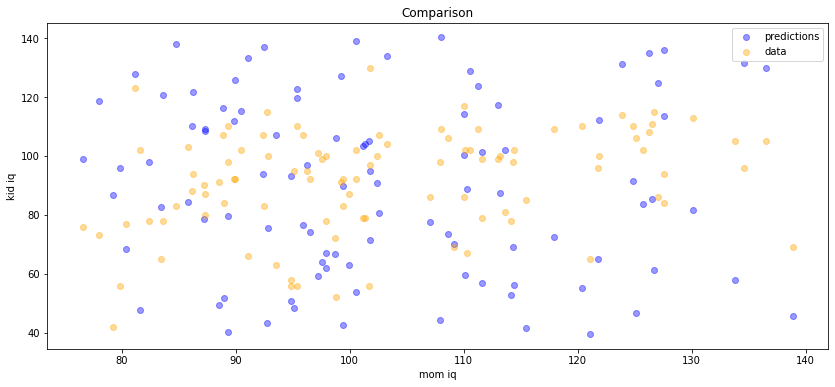

In [114]:
plt.figure(figsize=(14,6))
plt.scatter(df.mom_iq,kid_pred_prior[1], label="predictions",alpha=0.4,color='blue')
plt.scatter(df.mom_iq,df.kid_score, label="data", alpha =0.4,color='orange')
plt.title("Comparison")
plt.ylabel("kid iq")
plt.xlabel("mom iq")
plt.legend()
plt.show()

## Posterior

### STAN
```stan
data {
  int<lower=0> N;               
  array[N] real mom_iq;  
  array[N] real kid_score;      
}

parameters {
  real beta0;
  real beta1;
  real sigma;

}

model {
  beta0 ~ normal(90, 15);   
  beta1 ~ normal(0, 1); 
  sigma ~ student_t(4,0,1);
  for (i in 1:N) {
    kid_score[i] ~ normal(beta0 + beta1 * mom_iq[i], sigma);  
  }
}
generated quantities {

    array[N] real<lower=0> kid_score_pred; 
    array[N] real log_lik;

    for (i in 1:N) {
        log_lik[i] = normal_lpdf(kid_score[i] | beta0 + beta1 * mom_iq[i], sigma);
        kid_score_pred[i] = normal_rng(beta0 + beta1 * mom_iq[i], sigma);  
    }
}

```

In [115]:
model=CmdStanModel(stan_file='stan_models/model1_b.stan')

model_1_fit = model.sample(data = {'N': df.shape[0], 'mom_iq': df.mom_iq.values, 'kid_score': df.kid_score.values},
                     chains=4)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |███████▋  | 00:01 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▋ | 00:01 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


### Slopes

In [116]:
betas0 = model_1_fit.stan_variable('beta0')
betas1 = model_1_fit.stan_variable('beta1')
mom_iq = df['mom_iq']
for beta0, beta1 in zip(betas0, betas1):
    plt.plot(mom_iq, mom_iq * beta1 + beta0)
    plt.xlabel('mom_iq')
min_iq = 0
max_iq = 200
plt.axhline(y=min_iq, color='red', linestyle='--', label='Min IQ')
plt.axhline(y=max_iq, color='green', linestyle='--', label='Max IQ')

plt.grid(True)
plt.legend()
plt.show()

### Error bar

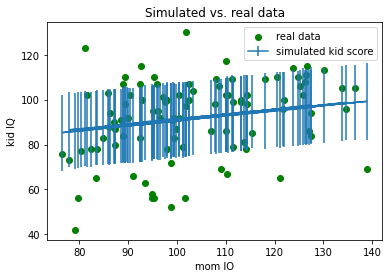

In [ ]:
kid_pred = model_1_fit.stan_variable('kid_score_pred')
mean_kid = np.mean(kid_pred,axis=0,)
std_kid = np.std(kid_pred,axis=0)
real_kid = np.array(df['kid_score'])
plt.errorbar(mom_iq, mean_kid, yerr=std_kid, label='simulated kid score')
plt.scatter(mom_iq, real_kid, label='real data', color ='green')
plt.xlabel('mom IO')
plt.ylabel('kid IQ')
plt.title('Simulated vs. real data')
plt.legend()
plt.show()

### Distributions of parameters

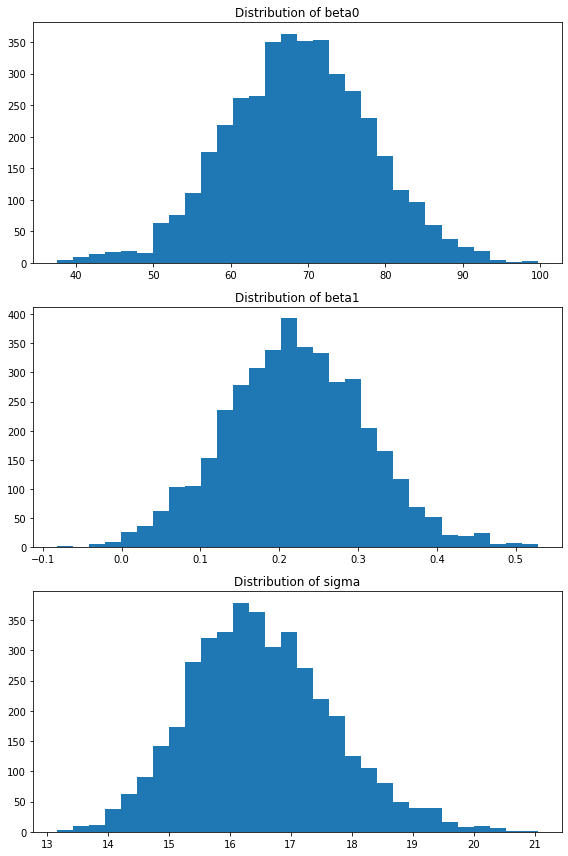

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

axs[0].hist(betas0, bins=30)
axs[0].set_title("Distribution of beta0")

axs[1].hist(betas1, bins=30)
axs[1].set_title("Distribution of beta1")

sigmas = model_1_fit.stan_variable("sigma")
axs[2].hist(sigmas, bins=30)
axs[2].set_title("Distribution of sigma")

plt.tight_layout()
plt.show()

### Comparison 

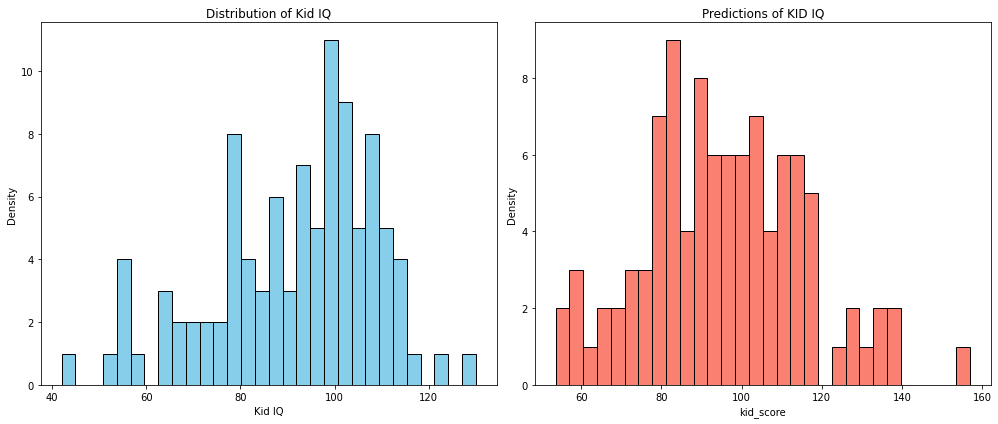

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].hist(df.kid_score, bins=30, color='skyblue', edgecolor='black')
axs[0].set_title('Distribution of Kid IQ')
axs[0].set_xlabel('Kid IQ')
axs[0].set_ylabel('Density')

axs[1].hist(kid_pred[0], bins=30, color='salmon', edgecolor='black')
axs[1].set_title('Predictions of KID IQ')
axs[1].set_xlabel('kid_score')
axs[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

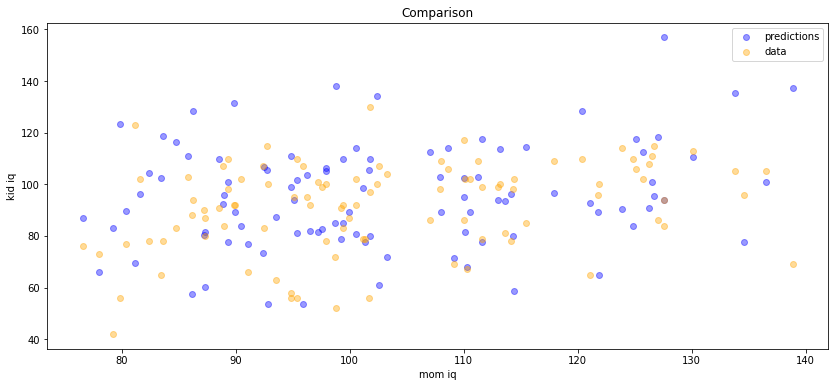

In [ ]:
plt.figure(figsize=(14,6))
plt.scatter(df.mom_iq,kid_pred[0], label="predictions",alpha=0.4,color='blue')
plt.scatter(df.mom_iq,df.kid_score, label="data", alpha =0.4,color='orange')
plt.title("Comparison")
plt.ylabel("kid iq")
plt.xlabel("mom iq")
plt.legend()
plt.show()

# Model 2

Our second model was extended by using an additional predictor in the form of information about whether the child's mother graduated from high school, which takes values from the set {0,1}. The model can be described as follows:

The kid's score ${kid\_score}_i$ is normally distributed with mean $\mu_i$ and standard deviation $\sigma$:

$$ \text{kid\_score}_i \sim N(\mu_i, \sigma) $$

The mean $\mu_i$ is defined as:

$$ \mu_i = \beta_0 + \beta_1 (\text{mom\_iq\_c}_i) + \beta_2 (\text{mom\_hs}_i) + \beta_3 (\text{mom\_iq\_c}_i \times \text{mom\_hs}_i) $$


#### Model components explanation:

- $\beta_0$ - represents the baseline kid's score when all predictors $ \text{mom\_iq\_c}_i\ $ and $ \text{mom\_hs}_i\ $ are zero. It captures the average kid's score for a hypothetical individual with a mother's IQ score of zero who did not graduate from high school.

- $\beta_1$ - measures the change in the expected kid's score for a one-unit increase in $ \text{mom\_iq\_c}_i\ $, assuming $ \text{mom\_hs}_i = 0\ $. It represents the effect of the mother's IQ on the kid's score when the mother did not graduate from high school.

- $\beta_2$ - indicates the average difference in the expected kid's score between children whose mothers graduated from high school $ \text{mom\_hs}_i = 1\ $ versus those who did not $ \text{mom\_hs}_i = 0\ $, assuming $ \text{mom\_iq\_c}_i = 0\ $.

- $\beta_3$ - allows for the possibility that the effect of $ \text{mom\_iq\_c}_i\ $ on the kid's score differs depending on whether the mother graduated from high school or not. It captures how the relationship between the mother's IQ and the kid's score changes based on the mother's educational attainment.

- $\sigma$ - error standard deviation: represents the variability of child IQ scores among those with the same maternal IQ score, it accounts for the unobserved factors affecting child IQ and is assumed to be constant across different levels of maternal IQ.

#### Input data required for the model:

- $N$ - the number of the rows with data in the dataset (number of samples),

- $\text{mom\_iq}$ - the array with the values of mom IQ score,

- $\text{mom\_hs}$ - the array, which contains the indicator values regarding the graduation of the high school.


### Priors 

The priors have been also selected based on the consideration of  the characteristics of the given data and the distributions recommended by Mark Lai in his book "Course Handouts for Bayesian Data Analysis Class" (2019) as follows:


The parameters $\beta$ are normally distributed:

$$ \beta_0 \sim N(90, 15) $$

$$ \beta_1 \sim N(0, 1) $$

$$ \beta_2 \sim N(0, 1) $$

$$ \beta_3 \sim N(0, 0.5) $$

The standard deviation $\sigma$ follows a t-distribution with 4 degrees of freedom, location 0, and scale 1:

$$ \sigma \sim t^+(4, 0, 1) $$


The prior scale is smaller for parameter $\beta_3$, because generally the magnitude of an interaction effect is smaller than the main effect.


### Simulating the data for posterior analysis

Similar to the first model, we standardized the mother's IQ data by subtracting the average score, ensuring that the intercept `c_mom_iq_model2 ` accurately reflects the child's expected IQ score when the mother's IQ is at the average level. In our process of creating the simulated dataset, we also generated a binary variable `mom_hs`, which signifies high school graduation, with a probability distribution of 20% for non-completion and 80% for high school graduation. This simulation readies the data for posterior analysis by maintaining the structure of the original dataset while introducing controlled variability.

In [ ]:
mean_weight = df['mom_iq'].mean()
df['c_mom_iq_model2'] = df['mom_iq'] - mean_weight
data_sim2 = {'N':df.shape[0], 'mom_iq':np.linspace(df.c_mom_iq_model2.min(),df.c_mom_iq_model2.max(), num=df.shape[0]), 'mom_hs': np.random.choice([0, 1], size=df.shape[0], p=[0.2, 0.8])}

### Prior model in `stan`:

```stan
data {
  int<lower=0> N; // number of observations               
  array[N] real mom_iq; // array of mother's IQ scores
  array[N] real mom_hs; // array of binary indicator for mother's high school education (0 or 1)

}

generated quantities {
  real beta0 = normal_rng(90, 15);   
  real beta1 = normal_rng(0, 1);
  real beta2 = normal_rng(0, 1);  
  real beta3 = normal_rng(0, 0.5);
  real sigma = student_t_rng(4, 0, 1);

  array[N] real kid_score;  // array to store simulated kid scores
  for (i in 1:N) {
    kid_score[i] = normal_rng(beta0 + beta1 * mom_iq[i] + beta2*mom_hs[i] + beta3*mom_iq[i]*mom_hs[i], sigma);  
  }
}

```

After the creation of the prior model in stan we started the sampling algorithm to generate samples from the posterior distribution of the model parameters:

In [ ]:
model_2=CmdStanModel(stan_file='stan_models/prior2.stan')

model_2_samp = model_2.sample(data = data_sim2,
                     chains=4,
                     seed=1204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |███▏      | 00:00 Iteration: 500 / 1000 [ 50%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed                      
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


We did not notice any problems during the sampling process. Next, we compared the orginal data with data from the prior analysis at the following plot:

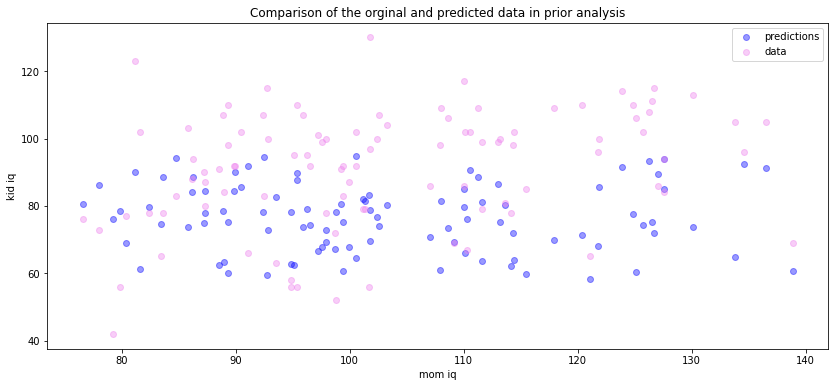

In [ ]:
kids_score_prior= model_2_samp.stan_variable("kid_score")

plt.figure(figsize=(14,6))
plt.scatter(df.mom_iq,kids_score_prior[2], label="predictions",alpha=0.4,color='blue')
plt.scatter(df.mom_iq,df.kid_score, label="data", alpha =0.4,color='violet')
plt.title("Comparison of the orginal and predicted data in prior analysis")
plt.ylabel("kid iq")
plt.xlabel("mom iq")
plt.legend()
plt.show()

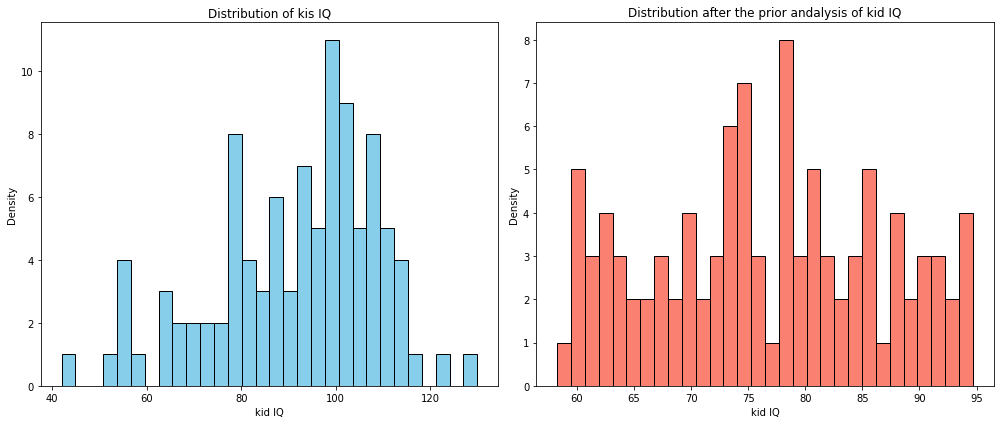

In [ ]:
fig, axs = plt.subplots(1,2 , figsize=(14, 6))

axs[0].hist(df.kid_score, bins=30, color='skyblue', edgecolor='black')
axs[0].set_title('Distribution of kis IQ')
axs[0].set_xlabel('kid IQ')
axs[0].set_ylabel('Density')

axs[1].hist(kids_score_prior[2], bins=30, color='salmon', edgecolor='black')
axs[1].set_title('Distribution after the prior andalysis of kid IQ')
axs[1].set_xlabel('kid IQ')
axs[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

Once the posterior analysis is completed we modified the prior model accordingly to be able to start the posterior analysis:

### Posterior model in `stan`:

```stan
data {
  int<lower=0> N;               // number of observations
  array[N] real mom_iq;         // array of mother's IQ scores
  array[N] real kid_score;      // array of kid's scores
  array[N] real mom_hs;         // aray indicating whether mother graduated from high school (0 or 1)
}

parameters {
  real beta0;                   
  real beta1;                   
  real beta2;                   
  real beta3;                   
  real sigma;          
}

model {
  // Priors
  beta0 ~ normal(90, 15);      // prior for intercept beta0
  beta1 ~ normal(0, 1);        // prior for beta1
  beta2 ~ normal(0, 1);        // prior for beta2
  beta3 ~ normal(0, 0.5);      // prior for beta3
  sigma ~ student_t(4, 0, 1);  // prior for sigma (using a Student-t distribution)

  for (i in 1:N) {
    kid_score[i] ~ normal(beta0 + beta1 * mom_iq[i] + beta2 * mom_hs[i] + beta3 * mom_iq[i] * mom_hs[i], sigma);

  }
}

generated quantities {
  array[N] real kid_score_pred;  // predicted kid's scores
  array[N] real log_lik;         // log-likelihood of observed data

  for (i in 1:N) {
    log_lik[i] = normal_lpdf(kid_score[i] | beta0 + beta1 * mom_iq[i] + beta2 * mom_hs[i] + beta3 * mom_iq[i] * mom_hs[i], sigma);
    kid_score_pred[i] = normal_rng(beta0 + beta1 * mom_iq[i] + beta2 * mom_hs[i] + beta3 * mom_iq[i] * mom_hs[i], sigma);
  }
}

```



In [ ]:
model=CmdStanModel(stan_file='stan_models/model2.stan')

model_2_fit = model.sample(data = {'N': df.shape[0], 'mom_iq': df.mom_iq.values, 'kid_score': df.kid_score.values, 'mom_hs': df.mom_hs.values},
                     chains=4)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▍         | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)



chain 1 |███████▋  | 00:01 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▋ | 00:01 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:02 Sampling completed                       
chain 2 |██████████| 00:02 Sampling completed                       
chain 3 |██████████| 00:02 Sampling completed                     


INFO:cmdstanpy:CmdStan done processing.


After the sampling from the model we have extracted the paremeter to check theirs distributions:

In [ ]:
kids_score_predictor_model2 = model_2_fit.stan_variable("kid_score_pred")
betas_0 = model_2_fit.stan_variable('beta0')
betas_1 = model_2_fit.stan_variable('beta1')
betas_2 = model_2_fit.stan_variable('beta2')
betas_3 = model_2_fit.stan_variable('beta3')
sigmas = model_2_fit.stan_variable('sigma')

Next, using the histograms we visualized the distribution of the child IQ score for the orginal data and the posterior data:

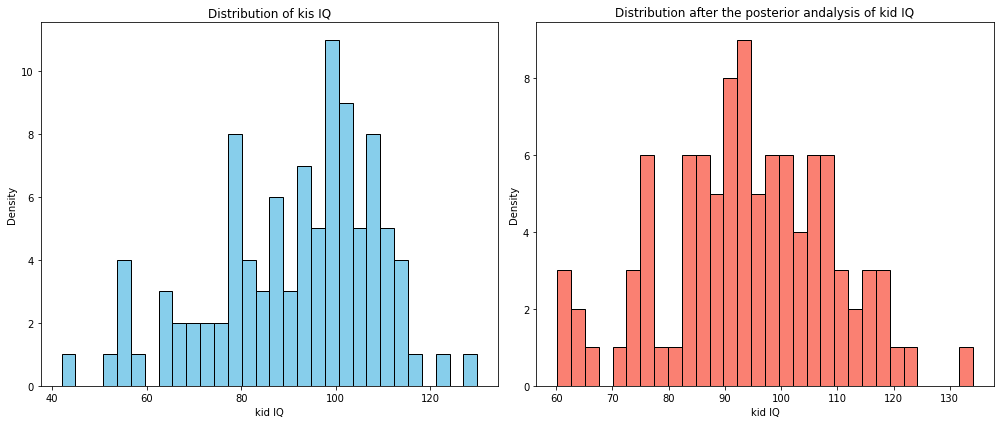

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6))

axs[0].hist(df.kid_score, bins=30, color='skyblue', edgecolor='black')
axs[0].set_title('Distribution of kis IQ')
axs[0].set_xlabel('kid IQ')
axs[0].set_ylabel('Density')

axs[1].hist(kids_score_predictor_model2[1], bins=30, color='salmon', edgecolor='black')
axs[1].set_title('Distribution after the posterior andalysis of kid IQ')
axs[1].set_xlabel('kid IQ')
axs[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

We calcualted alse the SSE (Sum Squared Error) error, which measures of the discrepancy between the real values (`real_kid_score`) and the values predicted by your model (`predicted_kid_score`):

In [ ]:
sum([(real_kid_score - predicted_kid_score)**2 for real_kid_score,predicted_kid_score in zip(df.kid_score, kids_score_predictor_model2[0])])

44827.19097584002

Next, we compared the predicted and real data using the sccatter plot:

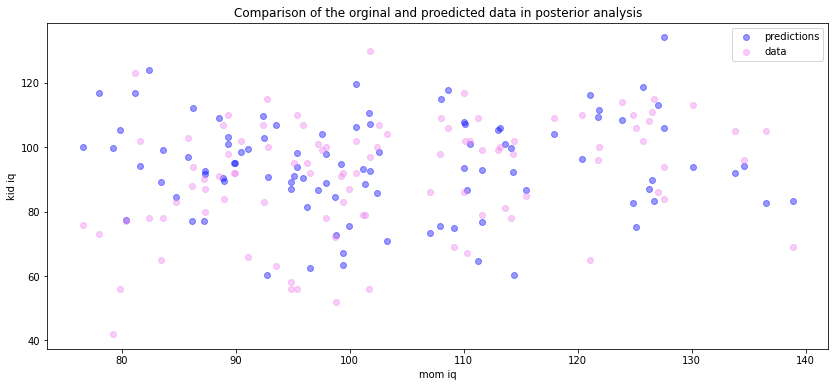

In [ ]:
plt.figure(figsize=(14,6))
plt.scatter(df.mom_iq,kids_score_predictor_model2[1], label="predictions",alpha=0.4,color='blue')
plt.scatter(df.mom_iq,df.kid_score, label="data", alpha =0.4,color='violet')
plt.title("Comparison of the orginal and proedicted data in posterior analysis")
plt.ylabel("kid iq")
plt.xlabel("mom iq")
plt.legend()
plt.show()

Finally, we have visualized the distribution of each parameter, which has been used in the model:

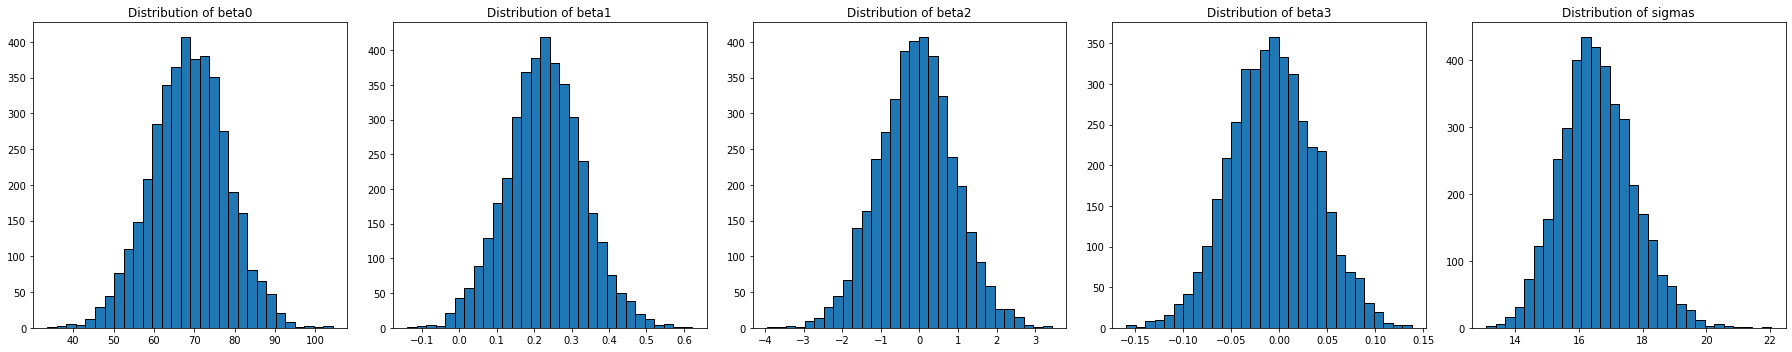

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5))

axs[0].hist(betas_0, bins=30, edgecolor='black')
axs[0].set_title("Distribution of beta0")

axs[1].hist(betas_1, bins=30,edgecolor='black')
axs[1].set_title("Distribution of beta1")

axs[2].hist(betas_2, bins=30, edgecolor='black')
axs[2].set_title("Distribution of beta2")

axs[3].hist(betas_3, bins=30, edgecolor='black')
axs[3].set_title("Distribution of beta3")

axs[4].hist(sigmas, bins=30,edgecolor='black')
axs[4].set_title("Distribution of sigmas")

plt.tight_layout()
plt.show()

# Model comparison


- Leave-one-out Cross Validation

<AxesSubplot:xlabel='Deviance'>

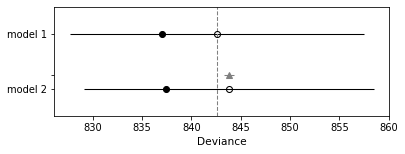

In [ ]:
comparison_dict = {"model 1":model_1_fit, "model 2": model_2_fit}
comparison_loo = az.compare(comparison_dict, ic="loo",scale="deviance")
az.plot_compare(comparison_loo)

In [ ]:
comparison_loo

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model 1,0,842.586079,2.785317,0.000000,1.0,14.934278,0.000000,False,deviance
model 2,1,843.814360,3.205545,1.228281,0.0,14.690678,0.479005,False,deviance


Comparison of the fisrt and the second model using Leave-One-Out Cross-Validation (LOO) showed that the first model has higher predictive accuracy. The less complex model achieved a lower LOO value of $ 842.29 $, compared to the more complex one's value of $ 844.00 $. Additionally, the Akaike weight, which approximates the probability of a model being the best in the set, was for the first model $ 1.0 $, which is much higher than for the second model $ 0.0 $. This suggests that the first model is the better model. In terms of complexity, the first model was a bit simpler, with an effective number of parameters $ p_{loo} $ equal to $ 2.63 $, compared to $ 3.30 $ in the second model. The standard errors for the LOO estimates for the models were $ 14.84 $ for the first model and $ 14.77 $ for the second model, highlighting the differences in the precision of the estimates between them.

- Widely Applicable Information Criterion

<AxesSubplot:xlabel='Deviance'>

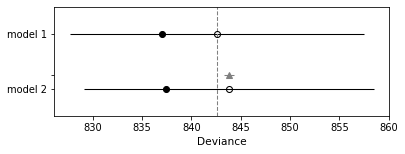

In [ ]:
comparison_waic = az.compare(comparison_dict, ic="waic",scale="deviance")
az.plot_compare(comparison_waic)

In [ ]:
comparison_waic

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model 1,0,842.568016,2.776285,0.000000,1.0,14.929582,0.000000,False,deviance
model 2,1,843.803100,3.199915,1.235084,0.0,14.689321,0.475721,False,deviance



The comparison of the less and the more complex models using the WAIC (Watanabe-Akaike Information Criterion) revealed that the first model has better predictive accuracy. The first model had a lower WAIC value of $ 842.28 $ compared to the second one's WAIC value of $ 843.97 $. Furthermore, the Akaike weight was significantly higher for the first model $ 1.0 $ than for the second model $ 0.0 $. The first model is slightly less complex and has a lower effective number of parameters $ p_{waic} = 2.63 $ compared to the second model $ 3.28 $. The standard errors of the WAIC estimates for both models were $ 14.83 $ and $ 14.76 $, respectively.

### Conclusion

The first model demonstrates better predictive accuracy than the second model, as confirmed by both WAIC and LOO metrics. The first model, which was the less complex one, achieved lower WAIC and LOO values and a higher Akaike weight, indicating its superior performance. Although the first model is simpler, the second one, despite its greater complexity, offers better performance. Differences in standard errors also highlight the superiority of the first model. As a result, the first model is the preferred choice in this analysis.


# References
Gelman, Andrew. 2006. “Prior distributions for variance parameters in hierarchical models (Comment on Article by Browne and Draper).” Bayesian Analysis 1 (3): 515–34. https://doi.org/10.1214/06-BA117A.